## Import libraries

In [3]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, MaxNLocator
warnings.simplefilter(action='ignore', category=FutureWarning)

## Fetch data

In [4]:
# generate a list of animals between QP032 and QP090
Animal_List = []
for i in range(32, 91):
    Animal_List.append('QP' + str(i).zfill(3))

In [5]:
# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_cont.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_cont = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_cont = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = ut.get_animal_data('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/',
                                             animal, 
                                             'SOUND_CAT_CONT',
                                             'Trial_Summary')
            all_data_cont = pd.concat([all_data_cont, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_cont, f)

In [6]:
# isolate the rows of the dataframe where Animal_ID = 'Q' and remove them, then re-index the dataframe
all_data_cont = all_data_cont[all_data_cont.Animal_ID != 'Q']
all_data_cont = all_data_cont.reset_index(drop=True)

## Filter data

In [7]:
data_df = ut.relabel_ELV(all_data_cont) # Re-label appropriately
# TODO: change block removal with date removal
data_df = ut.remove_blocks(data_df, 'QP032', [17, 18]) # blocks with wrong distribution
data_df = ut.remove_blocks(data_df, 'QP070', [38, 39, 
                                              49
                                              ]) # spout alignment problem
# only keep data where antibias is False or np.nan
data_df = data_df[(data_df.Anti_Bias == False) | (pd.isna(data_df.Anti_Bias))].reset_index(drop=True)
data_df = ut.filter_min_trials(data_df, 100) # Keep at least 100 valid trials per sessions
data_df = ut.threshold_cutoff(data_df, threshold = 0.7) # Only keep sessions where %correct is > threshold

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data_df = ut.filter_lapses(data_df, threshold = 0.75) # Remove sessions with lapse rates > 20%
    
data_df = ut.add_dist_block(data_df) # Track distribution and mouse specific block_nbs
data_df = ut.check_distributions(data_df, n = 1) # Check thal all subjects have been exposed to n distributions
# data_df = make_blocks_equal(data_df) # Check that all subjects have same number of blocks on each distribution (optional) 
data_df = data_df[data_df['Distribution'].notna()].reset_index(drop=True) # Check distributions are valid
# Ensure thal all blocks follow the desired order (e.g.   ['Uniform', 'Asym_right', 'Asym_left']) (optional)
# data_df = sort_consec_dist(data_df, ['Uniform', 'Asym_right', 'Asym_left']) 

In [8]:
# grab all rows of data_df where stim_relative is less than -1 OR greater than 1 and remove them, then re-index the dataframe
data_df = data_df[(data_df.stim_relative < 1) & (data_df.stim_relative > -1)].reset_index(drop=True)


In [9]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Check distributions

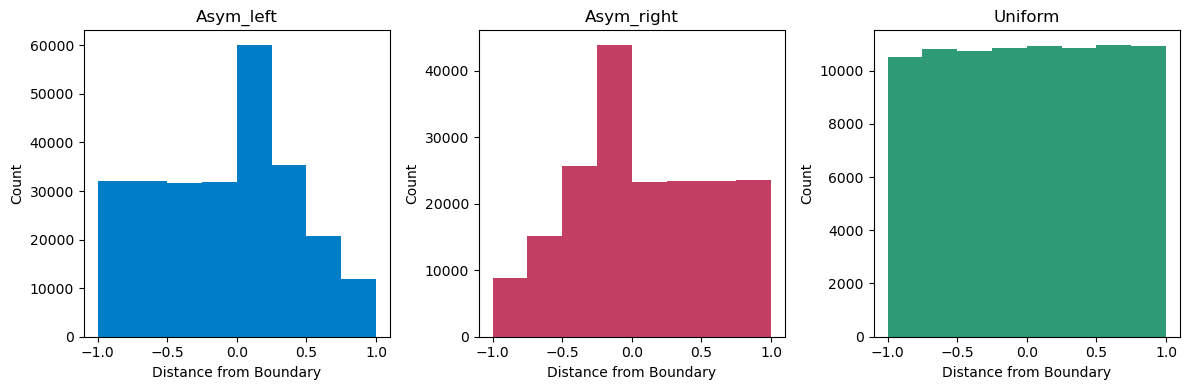

In [10]:
color_dict = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'}
ut.plot_dist_hist(data_df, color_dict, 8)

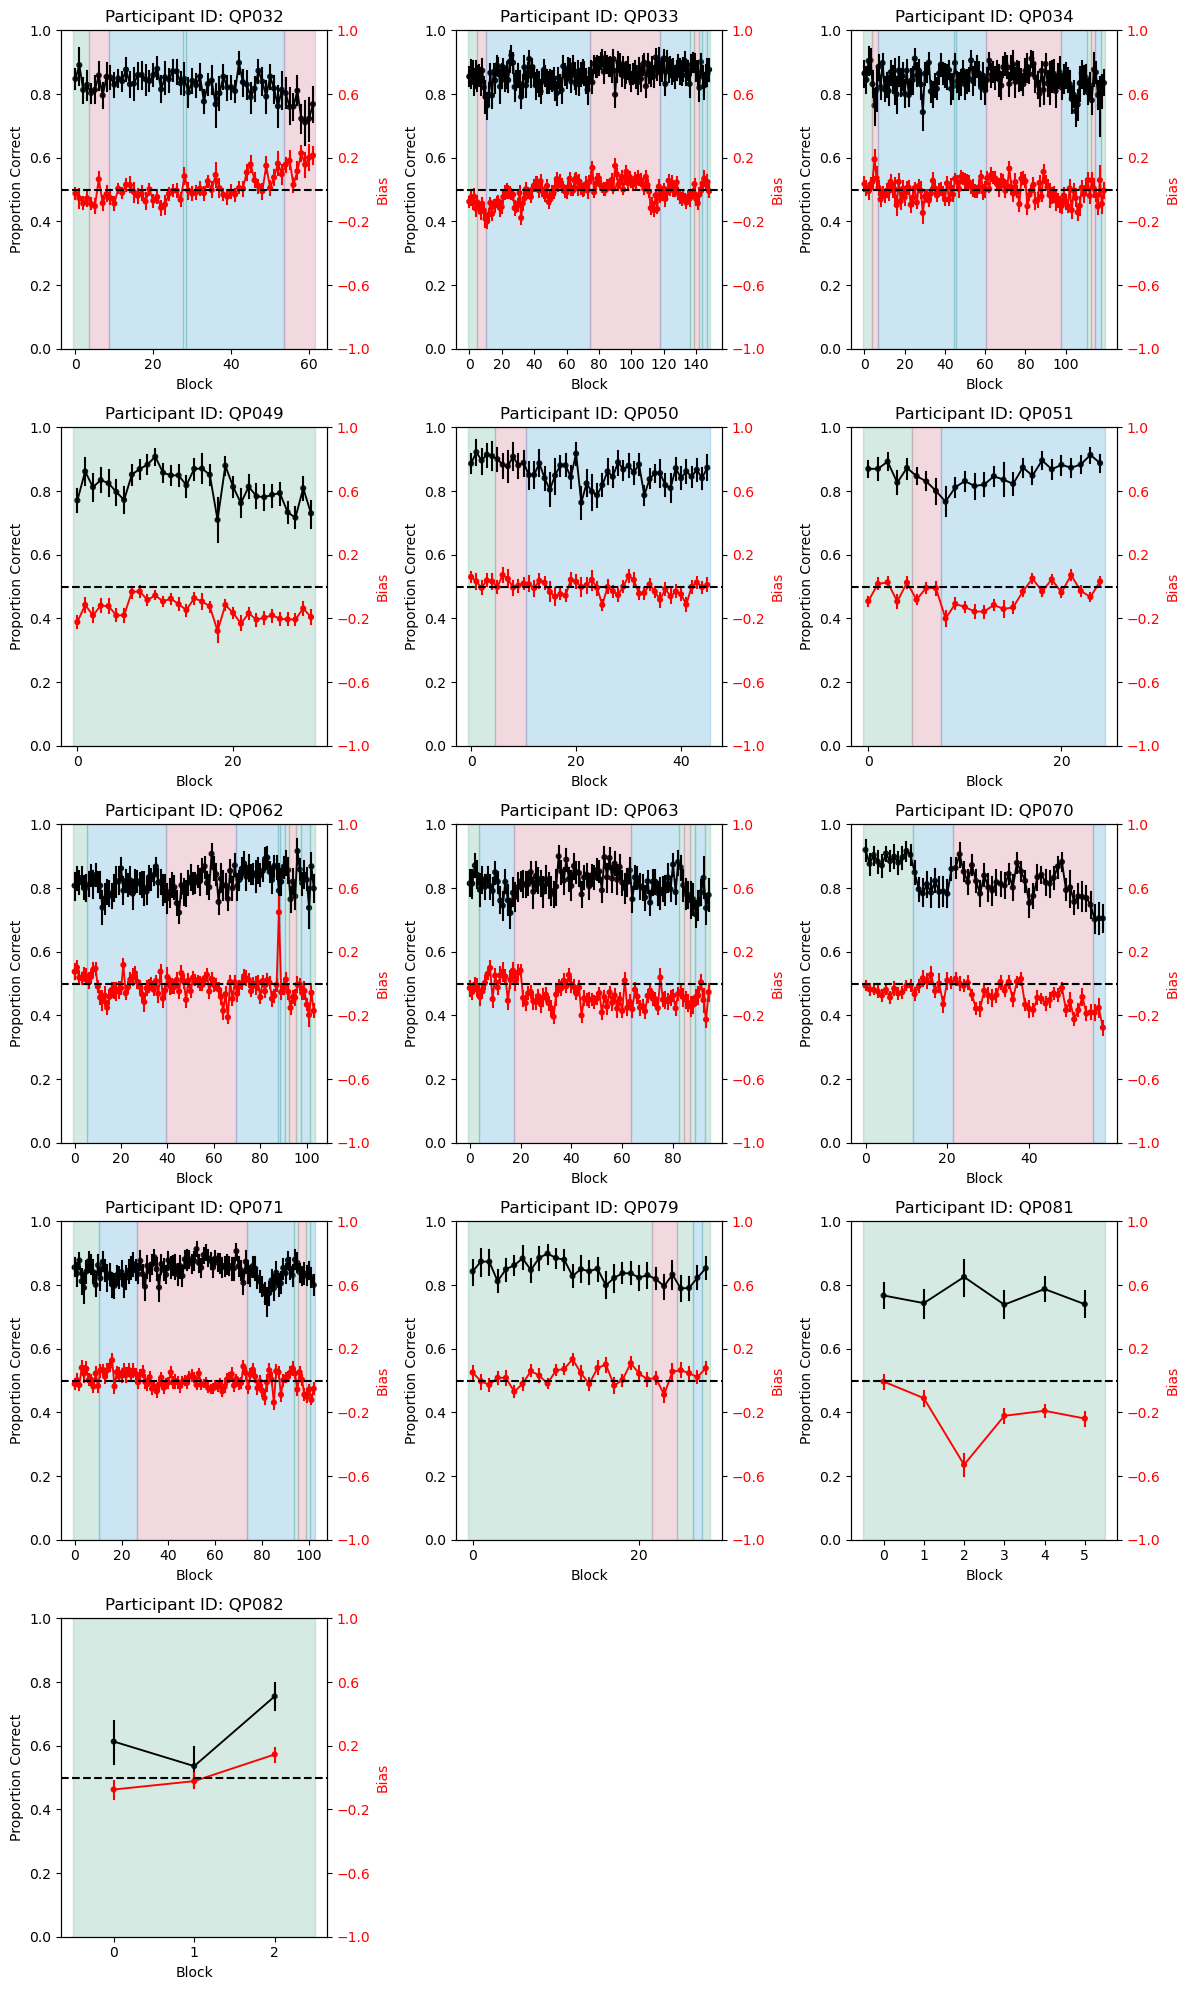

In [11]:
p_ids = ['QP032', 'QP033', 'QP034','QP049', 'QP050', 'QP051', 'QP062', 
         'QP063', 'QP070', 'QP071', 'QP079', 'QP081', 'QP082']
ut.plot_performance_and_bias(df = data_df,
                             participant_ids = p_ids,
                             distributions = ['Uniform', 'Asym_left', 'Asym_right'],
                             background_shading = True,
                             color_dict = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'})    

## Extract psychometric parameters

In [12]:
# extract pscyhometric parameters for all sessions
psych_params_df = ut.gen_blockwise_psych_params(data_df, p_ids)                       

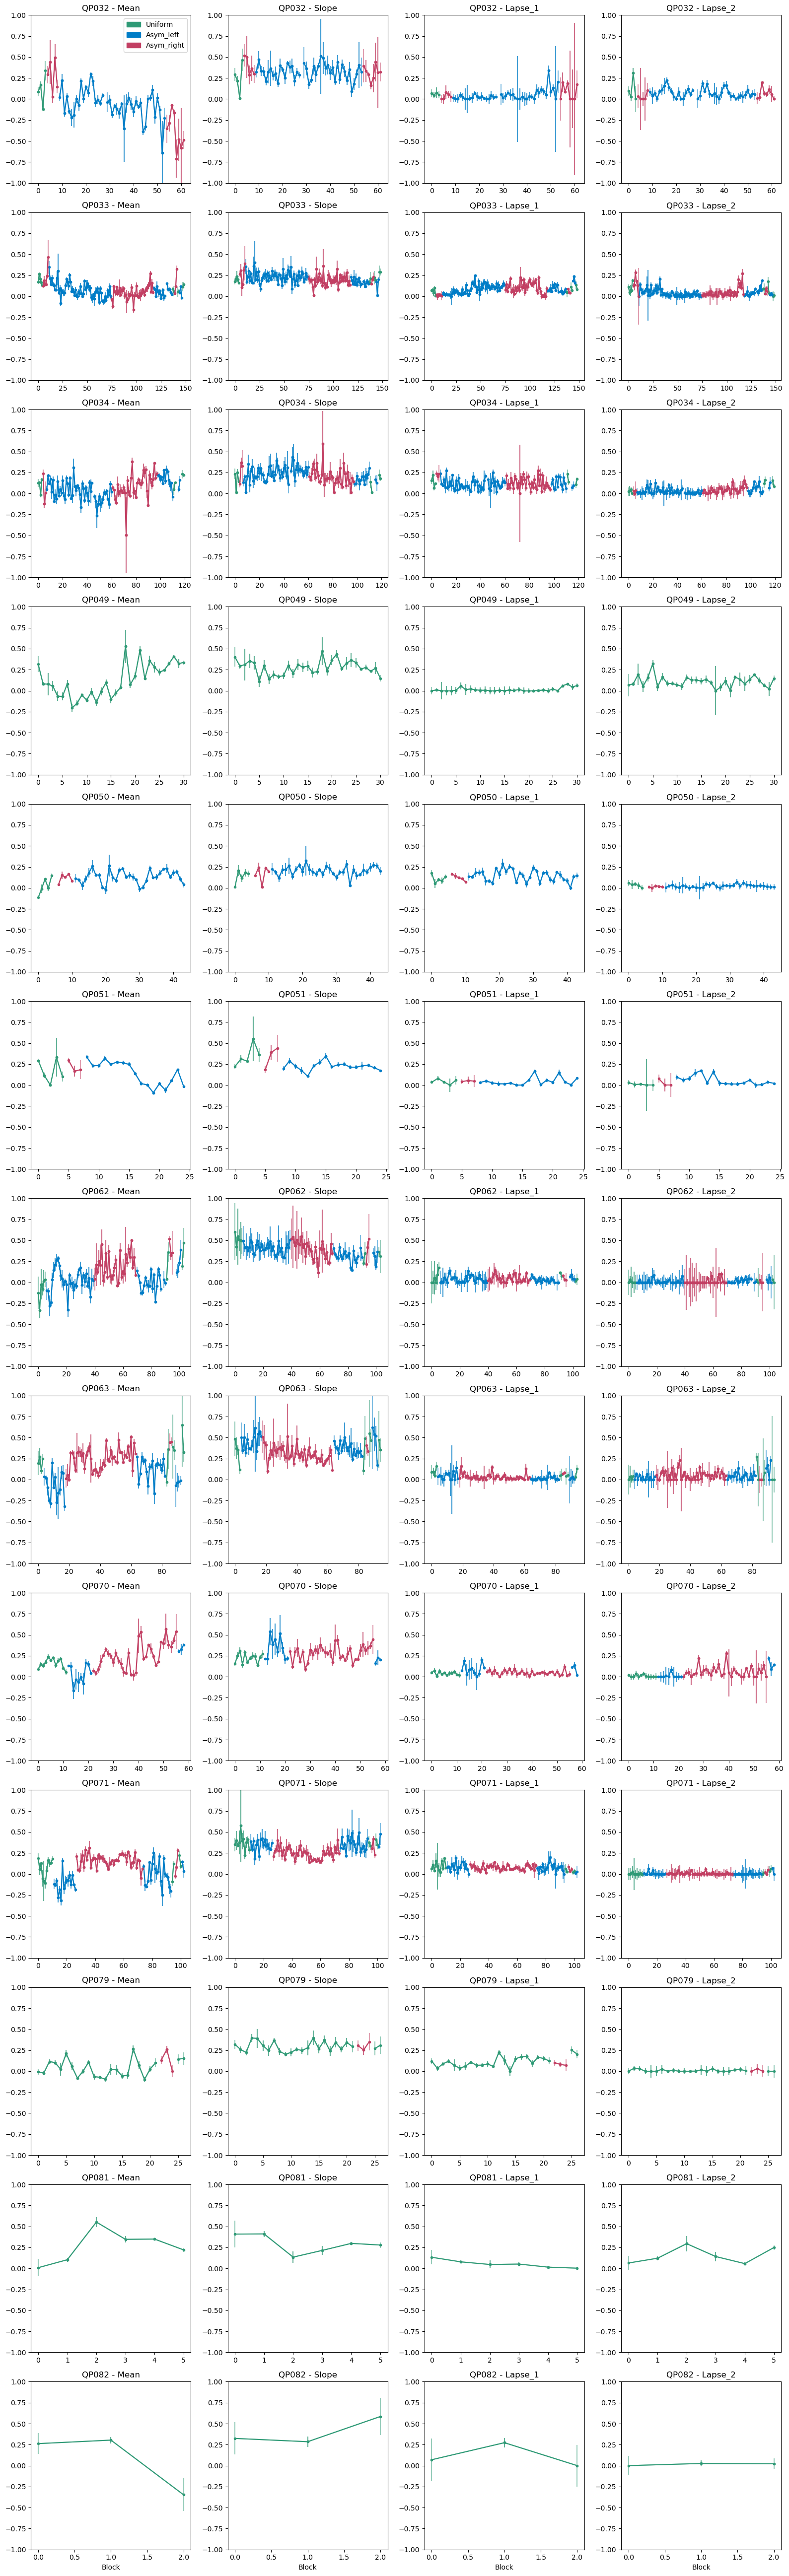

In [13]:
p_ids = ['QP032', 'QP033', 'QP034','QP049', 'QP050', 'QP051', 'QP062', 
         'QP063', 'QP070', 'QP071', 'QP079', 'QP081', 'QP082']   
clean_psych_params_df = psych_params_df[psych_params_df.Block_Slopes_Std <= 1.5] # remove outliers
ut.plot_blockwise_psych_params(df = clean_psych_params_df, 
                               participant_ids = p_ids)

## Look at psycho params just for the first transition

In [14]:
# add sequence column that tracks the number of distribution switches
clean_psych_params_df = ut.add_dist_sequence_number(clean_psych_params_df)

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/utils.py:1169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_psych_params_df.loc[:, 'Sequence'] = pd.Series(dtype='Int64')


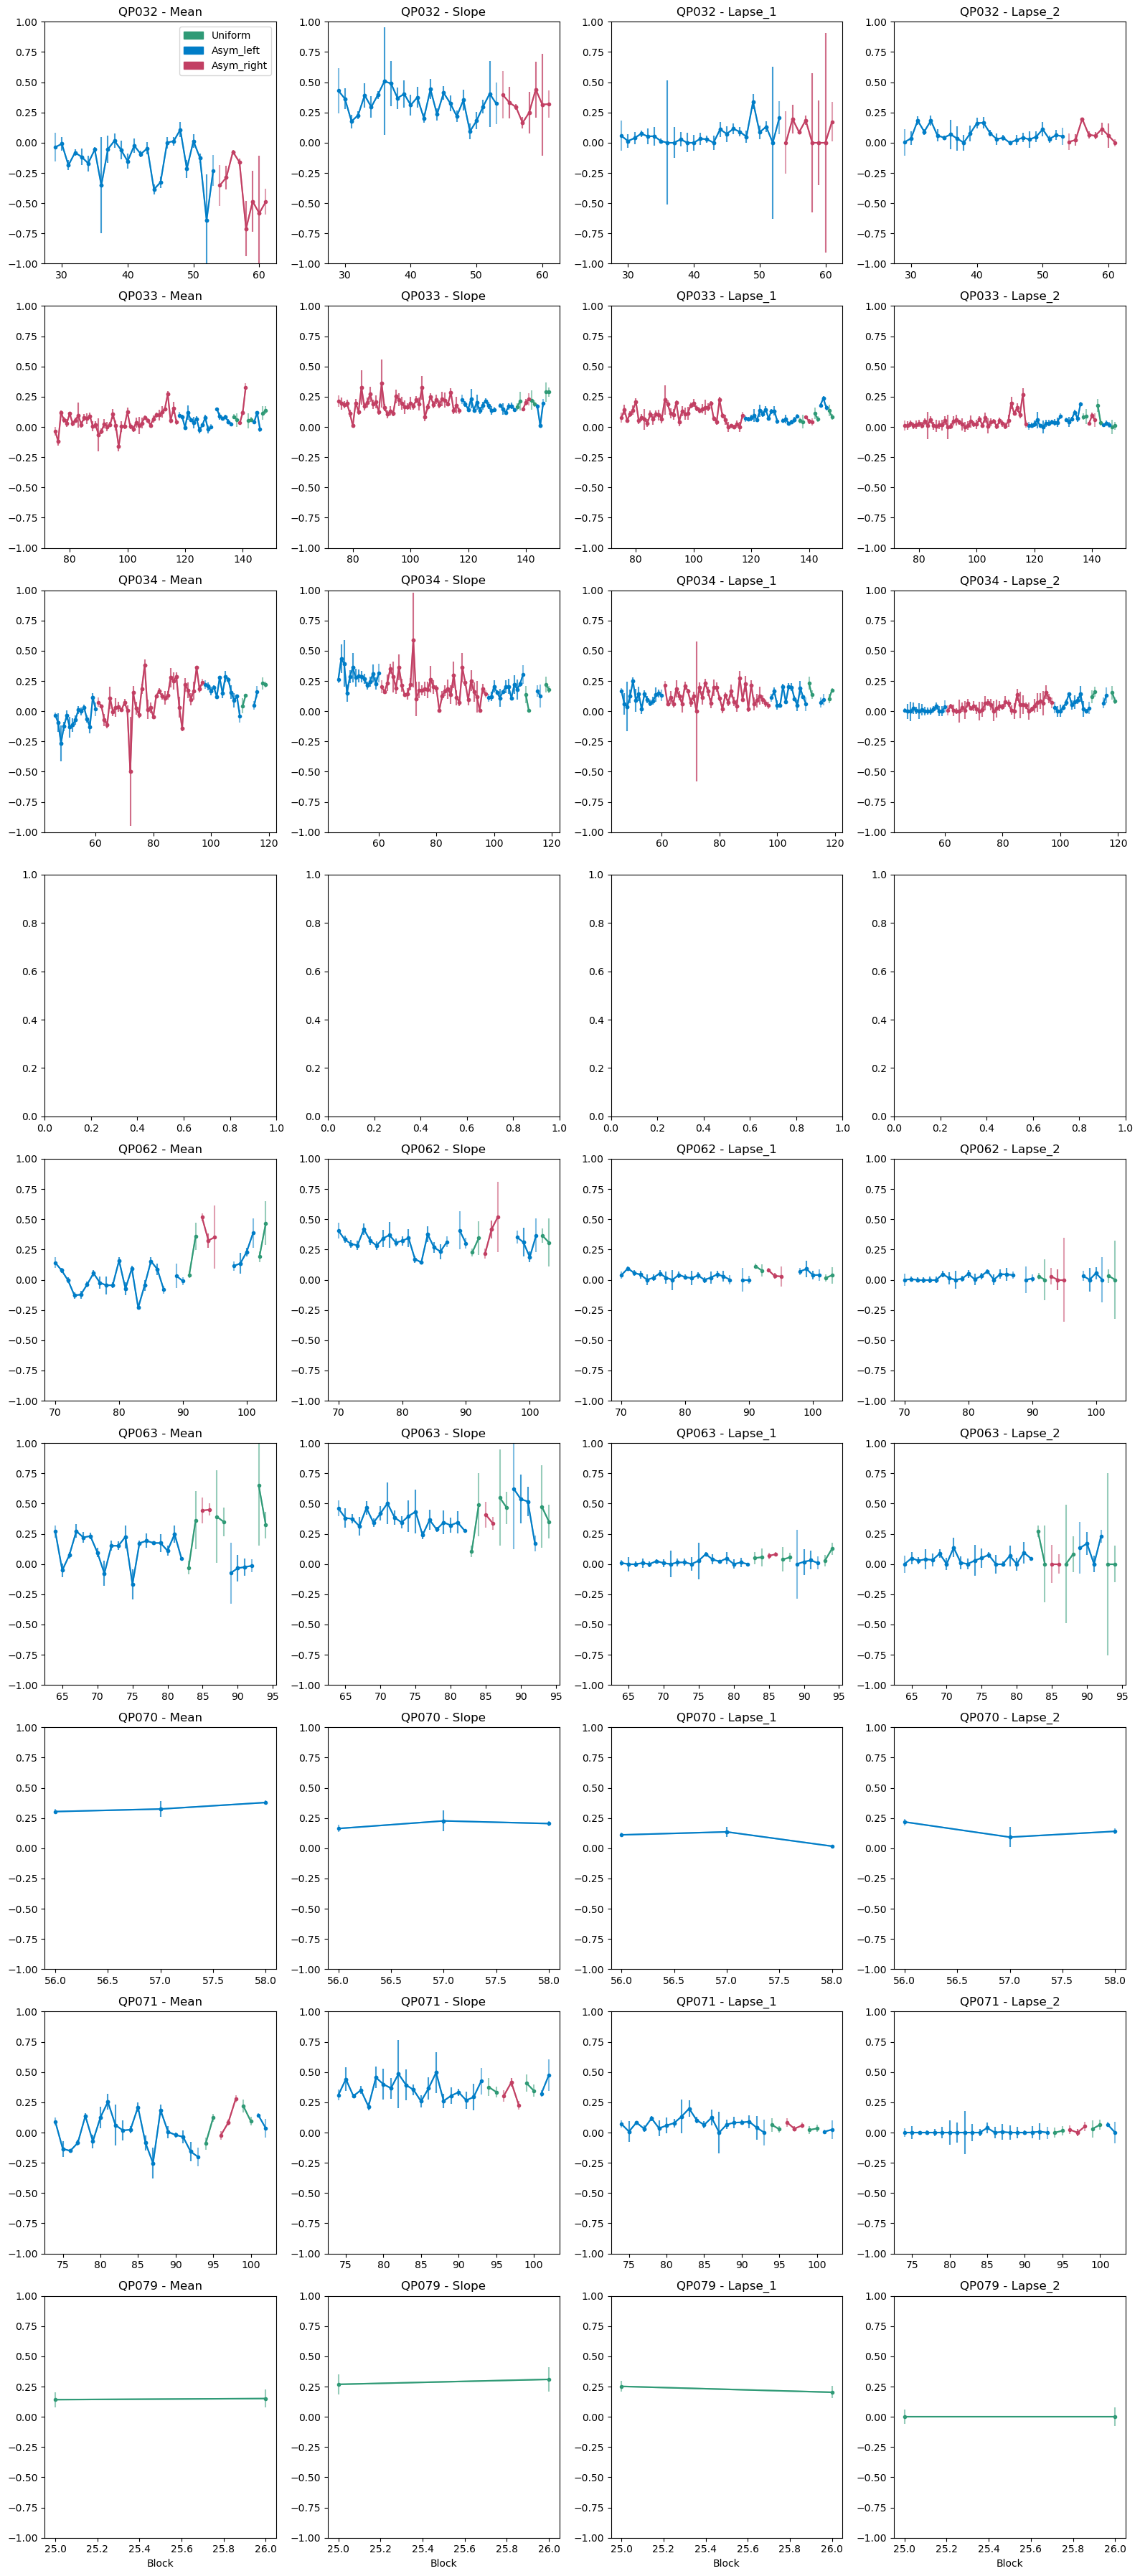

In [20]:
# only keep the rows of clean_psych_params_df where the sequence number is 0
clean_psych_params_df_seq_zero = clean_psych_params_df[
                                                        (clean_psych_params_df.Sequence > 0)
                                                    #    | 
                                                    #    (clean_psych_params_df.Sequence ==1)
                                                       ]
ut.plot_blockwise_psych_params(df = clean_psych_params_df_seq_zero, 
                               participant_ids = p_ids)